In [1]:
import fastai; 
fastai.__version__

In [2]:
from fastai.tabular import * 
from fastai.callbacks import EarlyStoppingCallback

In [3]:
# Reading data 
df = pd.read_csv("../../SMU_DS7331_Promotions_final/data/data_for_classification.csv")

# 1. Data Cleanup

**This is the same preprocesing that was done in Lab2 for SMU - DS7331 (Machine Learning 1 class). Please refer to that notebook for detailed explanation of what is being done.**

## 1.1 Remove Null Values

In [4]:
null_vals = df.isnull().sum(axis = 0)
print(null_vals[null_vals != 0])
df.dropna(inplace=True)

reporting_level_last                 14
accountability_matrix_label_last      3
functional_area_last                  3
job_family_label_last                 5
job_long_text_last                    6
operational_rollup_label_last       191
org_unit_desc_last                   44
dtype: int64


## 1.2 Remvove categorical variables with large number of levels 
**May reconsider later if using enbeddings in the NN**

In [5]:
categorical_features = df.select_dtypes(include='object').columns
categorical_features

Index(['worker', 'accountability_matrix_label_last', 'company_code_last',
       'cost_center_code_last', 'functional_area_last', 'supervisor_last',
       'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last',
       'job_long_text_last', 'operational_rollup_label_last',
       'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'site_desc_last', 'certificate_order_grp_last'],
      dtype='object')

In [6]:
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'worker': 66927
The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'supervisor_last': 9755
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The 

In [7]:
cols_to_del = ["supervisor_last"
               #,"org_unit_desc_last"
               #,"cost_center_code_last"
               #,"job_long_text_last"
               #,"site_city_code_last"
               #,"site_desc_last"  
               ,"year_last"
               ,"month_num_last"
               ,'months_since_promotion_max'
               ,"worker"
               ,"Unnamed: 0"
                ]
for column in df.columns:
    if column in cols_to_del:
        del df[column]

In [8]:
categorical_features = df.select_dtypes(include='object').columns
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The number of levels in column 'certificate_order_grp_last': 14


# 2. Modeling

## 2.1 Setup

In [9]:
from sklearn.model_selection import ShuffleSplit

In [10]:
path = "."

In [11]:
procs = [FillMissing, Categorify, Normalize]

## 2.2 Define the Data Object

### 2.2.1 Split into Train and Test Splits

In [12]:
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=101)
for train_index, test_index in rs.split(df):
    pass
    
print(len(train_index))
print(len(test_index))

75286
18822


In [13]:
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]
print(train_df.shape)
print(test_df.shape)

(75286, 68)
(18822, 68)


In [14]:
dep_var = 'promotion_max'
cat_names = list(categorical_features.values)
cont_names = list(set(train_df)-set(cat_names)-{dep_var})

In [15]:
print(cat_names)
print("")
print(cont_names)

['accountability_matrix_label_last', 'company_code_last', 'cost_center_code_last', 'functional_area_last', 'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last', 'job_long_text_last', 'operational_rollup_label_last', 'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last', 'site_country_region_last', 'site_country_segment_last', 'site_desc_last', 'certificate_order_grp_last']

['supervisor_Y_max', 'site_country_code_nunique', 'mgr_01_nunique', 'mgr_11_nunique', 'site_city_code_nunique', 'cost_center_code_nunique', 'tenure_in_months_last', 'promotion_cnt', 'job_long_text_nunique', 'supervisor_Y_last', 'movement_lateral_cnt_sum_last', 'accountability_matrix_label_nunique', 'site_country_region_nunique', 'gjs_sort_order_last', 'school_tier_last', 'hiredAfter200901_max', 'job_family_label_nunique', 'awards_points_cnt_sum_last', 'months_since_promotion_last', 'span_of_control_total_last', 'changed_spv_cnt_sum_last', 'org_unit_desc_nunique', 'functional_area_nuni

### 2.2.2 Define Custom DataBunch with Test Set

In [16]:
# If creating your own databunch, you will need to provide both categorical and continuous variable names
# If using the predefined databunch, it will pick whatever variable is not the target or the cat variables
train_tabular_list = TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
test_tabular_list  = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names)

In [17]:
## Create the DataBunch
data_bunch = (train_tabular_list
              .split_by_rand_pct(valid_pct=0.2, seed=101)  # Validation Split
              .label_from_df(cols=dep_var)  # Target
              .add_test(test_tabular_list)  # Test Split
              .databunch())  # Comnine into a databunch

### 2.2.2 (Alternate) Define Inbuilt DataBunch
* Does not have option for Test Set
* Also does not allow random validation split

In [18]:
# valid_idx = range(len(df)-int(0.2*len(df)), len(df))
# valid_idx

In [19]:
# data = TabularDataBunch.from_df(".", df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
# print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}
# print(data.train_ds.cat_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

In [20]:
data_bunch.show_batch()

accountability_matrix_label_last,company_code_last,cost_center_code_last,functional_area_last,gjs_code_label_last,gjs_framework_last,job_family_label_last,job_long_text_last,operational_rollup_label_last,org_unit_desc_last,site_city_code_last,site_country_code_last,site_country_region_last,site_country_segment_last,site_desc_last,certificate_order_grp_last,supervisor_Y_max,site_country_code_nunique,mgr_01_nunique,mgr_11_nunique,site_city_code_nunique,cost_center_code_nunique,tenure_in_months_last,promotion_cnt,job_long_text_nunique,supervisor_Y_last,movement_lateral_cnt_sum_last,accountability_matrix_label_nunique,site_country_region_nunique,gjs_sort_order_last,school_tier_last,hiredAfter200901_max,job_family_label_nunique,awards_points_cnt_sum_last,months_since_promotion_last,span_of_control_total_last,changed_spv_cnt_sum_last,org_unit_desc_nunique,functional_area_nunique,gjs_framework_nunique,supervisor_nunique,company_code_nunique,reporting_level_last,mgr_03_nunique,site_desc_nunique,mgr_02_nunique,comparatio_last,movement_demote_event_cnt_sum_last,mgr_10_nunique,awards_points_sum_last,awards_bonus_sum_last,mgr_05_nunique,transfer_event_cnt_sum_last,mgr_06_nunique,awards_peer_cnt_sum_last,mgr_08_nunique,ppa_rating_last,awards_bonus_cnt_sum_last,span_of_control_direct_last,mgr_12_nunique,mgr_07_nunique,site_country_segment_nunique,mgr_09_nunique,gjs_code_label_nunique,operational_rollup_label_nunique,mgr_04_nunique,spv_ppa_rating_last,target
Squadron,Stallsville,cc102018,MFG,T3,Technician Skilled Labor,StocktonDelta,MandellWeiss,Alamaditas,Cen,Shuffield,US,Americas,United States,Drytown,11-Pre-University,-0.4493,-0.1656,-0.9083,-0.1748,-0.2253,2.2564,1.4252,-0.6866,-0.5254,-0.3662,-0.3650,-0.3833,-0.1493,-0.0545,-0.3530,0.7633,-0.4754,-0.5833,-0.0428,-0.0811,0.3449,0.0362,-0.3252,-0.3279,-0.2382,-0.3874,-0.0830,-0.3498,-0.3350,-0.9084,0.6043,-0.2072,-0.3856,-0.5345,-0.2356,1.1851,1.3369,0.4028,-0.3340,-0.3933,-0.4045,-0.4026,-0.2455,-0.1007,-0.2557,-0.1762,-0.5941,-0.3670,1.0106,-0.0708,0.9001,1
Duenquat,CayucosMorro,cc551317,MFG,E3,Technical Engineering,Kidspace,Siddell,Bartome,Boedecker,Puetto,SG,Asia,Singapore,Tapie,04-Bachelor Level Degree - First Class,-0.4493,-0.1656,0.7107,-0.1748,-0.2253,3.2398,-0.0319,0.5166,-0.5254,-0.3662,-0.3650,-0.3833,-0.1493,0.7462,1.1404,-1.3101,-0.4754,-0.5833,0.5693,-0.0811,-0.1211,0.8002,-0.3252,-0.3279,0.3385,2.4627,-0.0830,0.2630,-0.3350,0.6936,0.2267,-0.2072,1.9952,-0.5345,-0.0605,1.6168,3.0750,1.2410,0.3049,1.3562,1.3587,0.5989,-0.2455,-0.1007,0.9359,-0.1762,1.2094,-0.3670,1.0106,-0.0708,0.9001,1
Squadron,Tobiason,cc692225,MFG,D1,Operator and Direct Labor,Tarrington,Naakea,Duffner,Terneros,Finder,CN,Asia,China,Bwokwanalejwa,12-Technical Certificates,-0.4493,-0.1656,-0.9083,-0.1748,-0.2253,-0.6937,-0.8229,-0.6866,-0.5254,-0.3662,-0.3650,-0.3833,-0.1493,-1.6560,-0.3530,0.7633,-0.4754,-0.5833,-0.5109,-0.0811,-0.1211,0.0362,-0.3252,-0.3279,-0.2382,-0.3874,-0.6991,-0.3498,-0.3350,-0.1074,-0.6802,-0.2072,-0.3856,-0.5345,-0.2356,-0.1098,-0.4012,-0.0163,-0.3340,-0.8306,-0.4045,-0.4026,-0.2455,-0.1007,-0.6529,-0.1762,-0.5941,-0.3670,-0.5062,-0.0708,0.9001,1
Duenquat,Clothespole,cc591100,MFG,D3,Operator and Direct Labor,Tarrington,Illil,Parkborough,Privett,Reall,JP,Asia,Japan,Samples,11-Pre-University,-0.4493,-0.1656,-0.9083,-0.1748,-0.2253,-0.6937,0.8736,0.5166,-0.5254,-0.3662,-0.3650,-0.3833,-0.1493,-1.0554,-0.3530,-1.3101,-0.4754,-0.5833,-1.0871,-0.0811,-1.0532,-0.7279,-0.3252,-0.3279,-0.8149,-0.3874,1.1491,-0.9627,-0.3350,-0.9084,-0.0130,-0.2072,-0.3856,-0.5345,-0.2356,-0.9731,-0.4012,-0.8544,-0.3340,-0.3933,-0.4045,-0.4026,-0.2455,-0.1007,-0.6529,-0.1762,0.0071,-0.3670,-0.5062,-0.9429,-0.6516,0
Duenquat,CayucosMorro,cc551908,MFG,T1,Technician Skilled Labor,Wirkkala,McKans,Bartome,los,Puetto,SG,Asia,Singapore,Chegwin,10-Diploma,-0.4493,-0.1656,-0.9083,-0.1748,-0.2253,0.2897,-0.8854,-0.6866,-0.5254,-0.3662,-0.3650,-0.3833,-0.1493,-0.4549,-0.3530,0.7633,-0.4754,0.0234,-0.6910,-0.0811,0.3449,-0

## 2.3 Compute Embedding Size

In [21]:
for cat in cat_names:
    df[cat] = df[cat].astype('category')

cat_szs = [len(df[col].cat.categories) for col in cat_names]
emb_szs = [min(50, (size+1)//2) for size in cat_szs]
emb_szs

[15, 25, 50, 2, 22, 5, 50, 50, 50, 50, 50, 14, 2, 6, 50, 7]

In [22]:
emb_szs_fastai = {name: value for (name, value) in zip(cat_names,emb_szs)}
emb_szs_fastai

{'accountability_matrix_label_last': 15,
 'company_code_last': 25,
 'cost_center_code_last': 50,
 'functional_area_last': 2,
 'gjs_code_label_last': 22,
 'gjs_framework_last': 5,
 'job_family_label_last': 50,
 'job_long_text_last': 50,
 'operational_rollup_label_last': 50,
 'org_unit_desc_last': 50,
 'site_city_code_last': 50,
 'site_country_code_last': 14,
 'site_country_region_last': 2,
 'site_country_segment_last': 6,
 'site_desc_last': 50,
 'certificate_order_grp_last': 7}

## 2.4 Define Learner

In [23]:
learn = tabular_learner(data_bunch,
                        layers=[200,100,50,10], 
                        emb_szs=emb_szs_fastai,
                        ps=0.1,
                        metrics=[accuracy, error_rate,
                                 Precision(average='micro'),
                                 Recall(average='micro'),
                                 FBeta(average='micro'),
                                 Precision(average='macro'),
                                 Recall(average='macro'),
                                 FBeta(average='macro')], #, ConfusionMatrix]
                        callback_fns = [partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.001, patience=2)] 
                       )
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [15]                 450        True      
______________________________________________________________________
Embedding            [25]                 1,150      True      
______________________________________________________________________
Embedding            [50]                 94,050     True      
______________________________________________________________________
Embedding            [2]                  8          True      
______________________________________________________________________
Embedding            [22]                 968        True      
______________________________________________________________________
Embedding            [5]                  50         True      
______________________________________________________________________
Embedding            [50]                 9,500      True      
_________________________________________________

## 2.5 Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


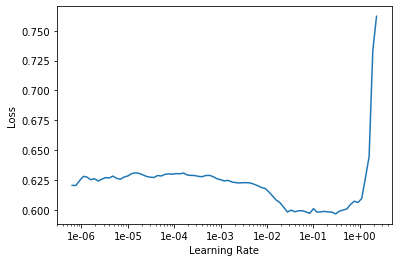

In [24]:
learn.lr_find()
learn.recorder.plot()

#### Learning Rate of 1e-2 seems to have the steepest downward slope. We will use this for training.

In [25]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,f_beta,precision,recall,f_beta,time
0,0.399262,0.395771,0.811715,0.188285,0.811715,0.811715,0.811715,0.776579,0.754403,0.757741,01:55
1,0.374435,0.351942,0.832769,0.167231,0.832769,0.832769,0.832769,0.798479,0.796885,0.797199,01:55
2,0.315562,0.341231,0.841403,0.158597,0.841403,0.841403,0.841403,0.814295,0.792645,0.796094,01:54
3,0.247031,0.346921,0.846384,0.153616,0.846384,0.846384,0.846384,0.813350,0.820577,0.819016,01:51
4,0.201176,0.365494,0.847181,0.152819,0.847181,0.847181,0.847181,0.819251,0.804957,0.807426,01:52


In [ ]:
# Why Micro values are same as accuracy
# https://forums.fast.ai/t/precision-recall-understanding-averages/41019

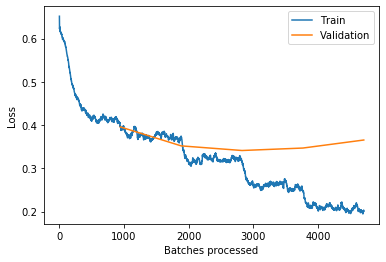

In [26]:
learn.recorder.plot_losses()

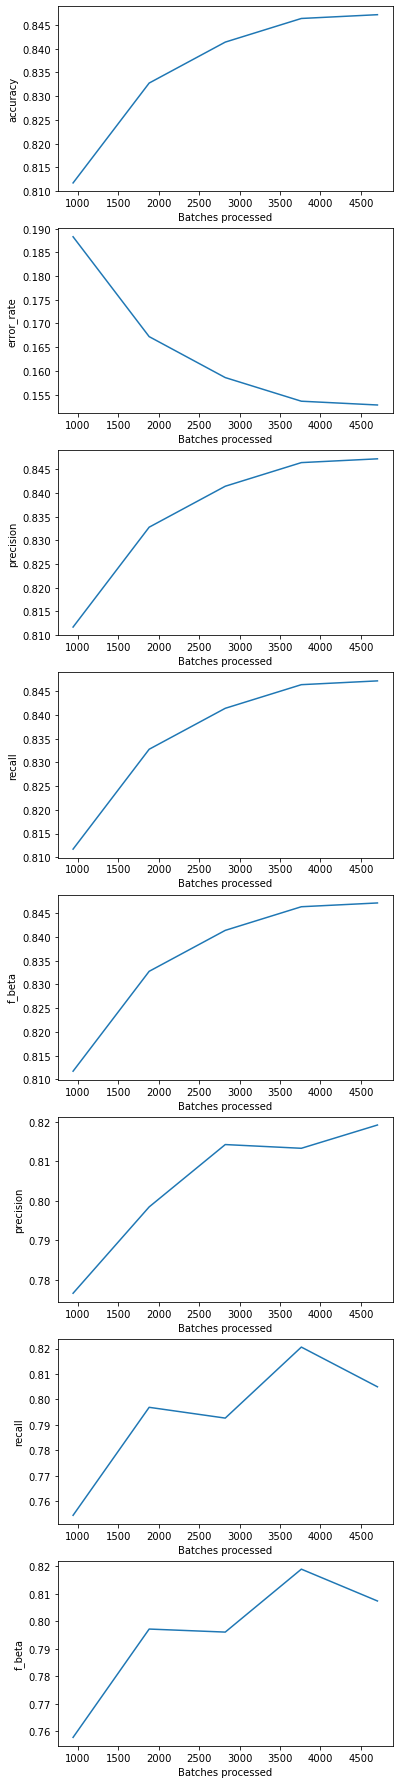

In [27]:
learn.recorder.plot_metrics()

# 3. Evaluations

## 3.1 Validation Set

### 3.1.1 Predictions

In [28]:
preds, target = learn.get_preds(ds_type=DatasetType.Valid)

In [29]:
print(preds.shape)
print(target.shape)

torch.Size([15057, 2])
torch.Size([15057])


In [30]:
print(preds[0:10])
print(preds[0:10].argmax(dim=1))
print(target[0:10])

tensor([[9.9948e-01, 5.1832e-04],
        [9.9961e-01, 3.9318e-04],
        [1.5427e-03, 9.9846e-01],
        [9.9980e-01, 2.0229e-04],
        [5.0828e-02, 9.4917e-01],
        [7.2617e-02, 9.2738e-01],
        [4.1031e-01, 5.8969e-01],
        [9.9597e-01, 4.0348e-03],
        [9.8537e-01, 1.4632e-02],
        [4.5997e-01, 5.4003e-01]])
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0])


### 3.1.2 Metrics

In [31]:
from sklearn.metrics import confusion_matrix
y_true = target
y_pred = preds.argmax(dim=1)
confusion_matrix(y_true, y_pred)

array([[9654,  990],
       [1311, 3102]], dtype=int64)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10644
           1       0.76      0.70      0.73      4413

    accuracy                           0.85     15057
   macro avg       0.82      0.80      0.81     15057
weighted avg       0.84      0.85      0.85     15057



## 3.2 Test Set

### 3.2.1 Predictions

In [33]:
# For test set, the targets are set to 0
# https://forums.fast.ai/t/getting-predictions-get-preds-for-test-sets/32077/6
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

### 3.2.2 Metrics

In [34]:
y_true = test_tabular_list.inner_df[dep_var]
y_pred = preds.argmax(dim=1)
confusion_matrix(y_true, y_pred)

array([[12225,  1243],
       [ 1600,  3754]], dtype=int64)

In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     13468
           1       0.75      0.70      0.73      5354

    accuracy                           0.85     18822
   macro avg       0.82      0.80      0.81     18822
weighted avg       0.85      0.85      0.85     18822



# Conclusions

1. Neural Network with Embeddings allow use of most categorical variables irrespective of the number of levels 
2. The Neural network above does not overfit (we used early stopping to prevent that in case it started overfitting). This can also be confirmed by looking at the confusion matrix of the test set and confirming that this is close to the confusion matrix for the validation set
3. In this case, results with the best rendom forest were slightly better than those obtained from the neural network. More work would be needed to see if the neural network model can be improved. 

# 5. TODO / Followups

* How to use a balanced dataset with fast.ai
* How to use custom metrics with fast.ai
* How to plot validation and train loss (similar to this: https://github.com/adriangrepo/my_fastai/blob/master/dl2/translate.ipynb)
* Lern how to use learn.predict with DataLoader instead of the Dataframe directly